The objective with this notebook is to convert the preprocessed structured input data into a form usable by our model. This includes one-hot encoding categorical data, normalizing value ranges, partitioning training vs testing datasets, class balancing, etc.

In [1]:
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from keras.utils import normalize
import matplotlib.pyplot as plt


categorical_feature_keys = [
    'PREV_GPA', 'HIGH_SCHOOL_GPA'
]

numeric_feature_keys = [
    'FM_UNMET_NEED', 'CURRENT_BALANCE', 'WI_GRADE_COUNT', 'DFW_GRADE_COUNT'
]
# Your path may vary, change this appropriately
datasets = '../../../data/'
path_to_stu_risk = f'{datasets}/interim/01-preprocess-structured-data-fine.csv'

# One of the things we love about pandas is that it's easy to load CSV data
# into a "data frame"
risk_raw_df = pd.read_csv(path_to_stu_risk)
risk_raw_df.describe()

Using TensorFlow backend.


,REG_HOLD_RISK,FM_UNMET_NEED,CURRENT_BALANCE,LAST_GPA,PREV_GPA,WI_GRADE_COUNT,DFW_GRADE_COUNT,FIRST_GENERATION_RISK,HIGH_SCHOOL_GPA
count,32167.000000,32167.000000,32167.000000,32167.000000,32167.000000,32167.000000,32167.000000,32167.000000,32167.000000
mean,0.109988,1800.908337,202.600652,7.370597,8.002425,0.692449,2.550129,0.304940,9.311904
std,0.312880,5378.941805,797.185971,3.573658,3.054022,1.793794,4.374338,0.460389,2.161410
min,0.000000,-43404.000000,-3488.290000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,6.000000,7.000000,0.000000,0.000000,0.000000,8.000000
50%,0.000000,0.000000,0.000000,8.000000,9.000000,0.000000,0.000000,0.000000,11.000000
75%,0.000000,0.000000,0.000000,10.000000,10.000000,1.000000,3.000000,1.000000,11.000000
max,1.000000,49745.000000,19475.000000,11.000000,11.000000,58.000000,59.000000,1.000000,11.000000


In [2]:
# Separate the data into input and output sets

x = risk_raw_df.copy()

# Elliminate the output data from the input dataset
x = x.drop('LAST_GPA', axis=1)

y = pd.DataFrame(risk_raw_df['LAST_GPA'])

In [11]:
x.head(5)

,REG_HOLD_RISK,FM_UNMET_NEED,CURRENT_BALANCE,WI_GRADE_COUNT,DFW_GRADE_COUNT,FIRST_GENERATION_RISK,PREV_GPA_F,PREV_GPA_D,PREV_GPA_D+,PREV_GPA_C-,...,HIGH_SCHOOL_GPA_D+,HIGH_SCHOOL_GPA_C-,HIGH_SCHOOL_GPA_C,HIGH_SCHOOL_GPA_C+,HIGH_SCHOOL_GPA_B-,HIGH_SCHOOL_GPA_B,HIGH_SCHOOL_GPA_B+,HIGH_SCHOOL_GPA_A-,HIGH_SCHOOL_GPA_A,HIGH_SCHOOL_GPA_GAP
0,1,0.000000,0.011127,0.000000,0.000000,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,-0.001966,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,0.001252,0.000000,0.014499,0.003304,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,0.000000,0.001905,0.000000,0.000000,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0,0.000000,0.000000,0.017399,0.012113,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [3]:
# Normalize the numeric fields 

for k in numeric_feature_keys:
    x[k] = normalize(x[k].values)[0]


In [4]:
# Let's name the columns of data to help keep track
grade_decode = {
    0: "F",  1: "D", 2: "D+", 3: "C-", 4: "C",
    5: "C+", 6: "B-", 7: "B", 8: "B+", 9: "A-", 10: "A", 11: 'GAP'
}
num_classes = len(grade_decode)

# Replacing the categorical value with the categorical features for our input dataset
for field in categorical_feature_keys:
    cat = to_categorical(x[field].values, num_classes=num_classes)
    for k, v in grade_decode.items():
        column = field + "_" + v
        x.insert(value=cat[:,k], loc=len(x.columns), column=column)
    x = x.drop(field, axis=1)

# Replacing the categorical value with the categorical features for our output dataset
cat = to_categorical(y['LAST_GPA'].values, num_classes=num_classes)
for k, v in grade_decode.items():
    column = 'LAST_GPA_' + v
    y.insert(value=cat[:,k], loc=len(y.columns), column=column)
y = y.drop('LAST_GPA', axis=1)

y.head(5)

,LAST_GPA_F,LAST_GPA_D,LAST_GPA_D+,LAST_GPA_C-,LAST_GPA_C,LAST_GPA_C+,LAST_GPA_B-,LAST_GPA_B,LAST_GPA_B+,LAST_GPA_A-,LAST_GPA_A,LAST_GPA_GAP
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The data formatting is now readable by our model. Now it's time to seperate the data into training and testing collections. We will start with 80% for training, and 20% for testing. There should be an even proportion of classes divided between the two collections. Let's get a baseline of the distribution in the whole dataset.

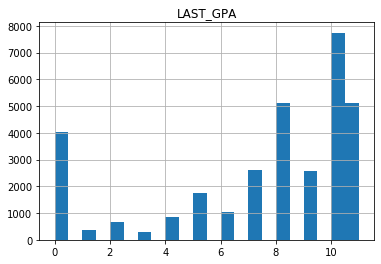

In [5]:
risk_raw_df.hist(column='LAST_GPA',bins=22)
plt.show()

In [6]:
# Splitting into train and test sets with an 80/20 proportion

total_rows = x.shape[0]
msk = np.random.rand(total_rows) < 0.8

x_train = x[msk]
y_train = y[msk]

x_test = x[~msk]
y_test = y[~msk]

In [7]:
x_train.head(5)

,REG_HOLD_RISK,FM_UNMET_NEED,CURRENT_BALANCE,WI_GRADE_COUNT,DFW_GRADE_COUNT,FIRST_GENERATION_RISK,PREV_GPA_F,PREV_GPA_D,PREV_GPA_D+,PREV_GPA_C-,...,HIGH_SCHOOL_GPA_D+,HIGH_SCHOOL_GPA_C-,HIGH_SCHOOL_GPA_C,HIGH_SCHOOL_GPA_C+,HIGH_SCHOOL_GPA_B-,HIGH_SCHOOL_GPA_B,HIGH_SCHOOL_GPA_B+,HIGH_SCHOOL_GPA_A-,HIGH_SCHOOL_GPA_A,HIGH_SCHOOL_GPA_GAP
0,1,0.000000,0.011127,0.000000,0.000000,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,-0.001966,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,0.001252,0.000000,0.014499,0.003304,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0.000000,0.000000,0.017399,0.012113,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0,0.000000,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
y_train.head(5)

,LAST_GPA_F,LAST_GPA_D,LAST_GPA_D+,LAST_GPA_C-,LAST_GPA_C,LAST_GPA_C+,LAST_GPA_B-,LAST_GPA_B,LAST_GPA_B+,LAST_GPA_A-,LAST_GPA_A,LAST_GPA_GAP
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [9]:
x_train.to_csv(f'{datasets}/interim/x_train-fine.csv', index=False)
y_train.to_csv(f'{datasets}/interim/y_train-fine.csv', index=False)
x_test.to_csv(f'{datasets}/interim/x_test-fine.csv', index=False)
y_test.to_csv(f'{datasets}/interim/y_test-fine.csv', index=False)

In [10]:
(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

((25673, 30), (25673, 12), (6494, 30), (6494, 12))

In [34]:
x_test.head(5)

,REG_HOLD_RISK,FM_UNMET_NEED,CURRENT_BALANCE,WI_GRADE_COUNT,DFW_GRADE_COUNT,FIRST_GENERATION_RISK,PREV_GPA_F,PREV_GPA_D,PREV_GPA_D+,PREV_GPA_C-,...,HIGH_SCHOOL_GPA_D+,HIGH_SCHOOL_GPA_C-,HIGH_SCHOOL_GPA_C,HIGH_SCHOOL_GPA_C+,HIGH_SCHOOL_GPA_B-,HIGH_SCHOOL_GPA_B,HIGH_SCHOOL_GPA_B+,HIGH_SCHOOL_GPA_A-,HIGH_SCHOOL_GPA_A,HIGH_SCHOOL_GPA_GAP
1,0,-0.001966,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,0.000000,0.001905,0.000000,0.000000,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,1,0.000000,0.013421,0.020298,0.009911,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,1,0.000000,0.002759,0.008699,0.013214,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10,0,0.012883,0.000000,0.000000,0.012113,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
